In [2]:
# Loading the basic libraries for CNN

import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import seaborn as sb
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from keras.utils import np_utils
from sklearn.model_selection import train_test_split




%pylab inline



Populating the interactive namespace from numpy and matplotlib


Let us Load the Kaggle Leaf data set. This is about identifying various leaves in the forest.

Loading the training and test data from Kaggle 

In [3]:

train_data = pd.read_csv('train.csv.zip')
test_data  = pd.read_csv('test.csv.zip')




Let us do some basic EDA on the data sets provided 

In [4]:
train_data.head()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Columns: 194 entries, id to texture64
dtypes: float64(192), int64(1), object(1)
memory usage: 1.5+ MB


In [6]:
test_data.head()

,id,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,4,0.019531,0.009766,0.078125,0.011719,0.003906,0.015625,0.005859,0.0,0.005859,...,0.006836,0.000000,0.015625,0.000977,0.015625,0.0,0.0,0.000000,0.003906,0.053711
1,7,0.007812,0.005859,0.064453,0.009766,0.003906,0.013672,0.007812,0.0,0.033203,...,0.000000,0.000000,0.006836,0.001953,0.013672,0.0,0.0,0.000977,0.037109,0.044922
2,9,0.000000,0.000000,0.001953,0.021484,0.041016,0.000000,0.023438,0.0,0.011719,...,0.128910,0.000000,0.000977,0.000000,0.000000,0.0,0.0,0.015625,0.000000,0.000000
3,12,0.000000,0.000000,0.009766,0.011719,0.017578,0.000000,0.003906,0.0,0.003906,...,0.012695,0.015625,0.002930,0.036133,0.013672,0.0,0.0,0.089844,0.000000,0.008789
4,13,0.001953,0.000000,0.015625,0.009766,0.039062,0.000000,0.009766,0.0,0.005859,...,0.000000,0.042969,0.016602,0.010742,0.041016,0.0,0.0,0.007812,0.009766,0.007812


In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594 entries, 0 to 593
Columns: 193 entries, id to texture64
dtypes: float64(192), int64(1)
memory usage: 895.8 KB


In [8]:
# Label Encoder for the leaves 

def encode(train, test):
    label_encoder = LabelEncoder().fit(train.species)
    labels = label_encoder.transform(train.species)
    classes = list(label_encoder.classes_)

    train = train.drop(['species', 'id'], axis=1)
    test_ids=test.id
    test = test.drop('id', axis=1)

    return train, labels, test, classes,test_ids

In [9]:
# Encode the data 
train_data, labels, test_data, classes,test_ids = encode(train_data, test_data)

In [10]:
# Let's see what's the shape of the data

train_data.shape

(990, 192)

In [11]:
# Scaling the data using Standard scaler 
scaler = StandardScaler().fit(train_data.values)
scaled_train = scaler.transform(train_data.values)

In [12]:
# Split the data for Training and Test
sss = StratifiedShuffleSplit(test_size=0.1, random_state=23)
for train_index, valid_index in sss.split(scaled_train, labels):
    X_train, X_test = scaled_train[train_index], scaled_train[valid_index]
    y_train, y_test = labels[train_index], labels[valid_index]

In [13]:
nb_features = 64 # number of features per features type (shape, texture, margin)   
nb_class = len(classes)

In [73]:
nb_class

99

In [14]:
# reshape train data
X_train_r = np.zeros((len(X_train), nb_features, 3))
X_train_r[:, :, 0] = X_train[:, :nb_features]
X_train_r[:, :, 1] = X_train[:, nb_features:128]
X_train_r[:, :, 2] = X_train[:, 128:]

# reshape validation data
X_test_r = np.zeros((len(X_test), nb_features, 3))
X_test_r[:, :, 0] = X_test[:, :nb_features]
X_test_r[:, :, 1] = X_test[:, nb_features:128]
X_test_r[:, :, 2] = X_test[:, 128:]

In [15]:
print("x_train dim: ",X_train_r.shape)
print("x_test dim:   ",X_test_r.shape)

x_train dim:  (891, 64, 3)
x_test dim:    (99, 64, 3)


In [16]:
# Keras model with one Convolution1D layer

model_1 = Sequential()
model_1.add(Convolution1D(512, 1, input_shape=(nb_features, 3)))
model_1.add(Activation('relu'))
#model_1.add(Convolution1D(128, 1))
#model_1.add(Activation('relu'))
model_1.add(Flatten())
model_1.add(Dropout(0.4))
model_1.add(Dense(2048, activation='relu'))
model_1.add(Dense(1024, activation='relu'))
model_1.add(Dense(nb_class))
model_1.add(Activation('softmax'))

In [17]:
# Compiling and fitting the model with the training data 
# Here we are using a 20% Validation data set 


y_train = np_utils.to_categorical(y_train, nb_class)
y_test = np_utils.to_categorical(y_test, nb_class)

sgd = SGD(lr=0.01, nesterov=True, decay=1e-6, momentum=0.9)
model_1.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

cb1 = EarlyStopping(patience = 3, restore_best_weights=True, monitor = 'val_acc')
cb2 = ReduceLROnPlateau(patience = 4, min_lr=0.00001, factor = 0.4, monitor = 'val_acc')


#model_1.fit(X_train_r, y_train, epochs=15, validation_data=(X_valid_r, y_valid), batch_size=160)
history = model_1.fit(X_train_r, y_train, epochs=15, validation_split=0.2, batch_size=160, callbacks = [cb1, cb2], verbose = 1)



#cb1 = EarlyStopping(patience = 3, restore_best_weights=True, monitor = 'val_acc')
#cb2 = ReduceLROnPlateau(patience = 4, min_lr=0.00001, factor = 0.4, monitor = 'val_acc')

#history = model_1.fit(X_train_r, y_train, validation_split=0.2, epochs = 200, batch_size = 140, callbacks = [cb1, cb2], verbose = 1)




Epoch 1/15


/usr/local/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


5/5 [==============================] - 3s 530ms/step - loss: 4.5839 - accuracy: 0.0098 - val_loss: 4.5388 - val_accuracy: 0.0503 - lr: 0.0100
Epoch 2/15
5/5 [==============================] - 2s 478ms/step - loss: 4.4988 - accuracy: 0.0815 - val_loss: 4.4298 - val_accuracy: 0.1788 - lr: 0.0100
Epoch 3/15
5/5 [==============================] - 2s 497ms/step - loss: 4.3574 - accuracy: 0.2697 - val_loss: 4.2845 - val_accuracy: 0.3073 - lr: 0.0100
Epoch 4/15
5/5 [==============================] - 3s 542ms/step - loss: 4.1663 - accuracy: 0.3975 - val_loss: 4.0807 - val_accuracy: 0.3743 - lr: 0.0100
Epoch 5/15
5/5 [==============================] - 3s 516ms/step - loss: 3.8877 - accuracy: 0.4874 - val_loss: 3.7947 - val_accuracy: 0.3911 - lr: 0.0100
Epoch 6/15
5/5 [==============================] - 3s 600ms/step - loss: 3.5020 - accuracy: 0.5421 - val_loss: 3.4025 - val_accuracy: 0.4134 - lr: 0.0100
Epoch 7/15
5/5 [==============================] - 3s 562ms/step - loss: 2.9731 - accuracy: 0.

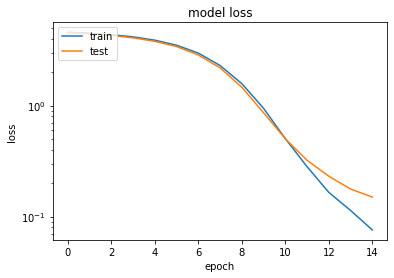

In [18]:
## summarize history for loss
## Plotting the loss with the number of iterations
plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

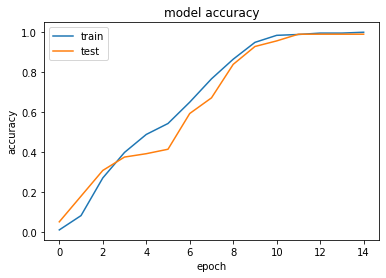

In [19]:
## Plotting the error with the number of iterations
## With each iteration the error reduces smoothly
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

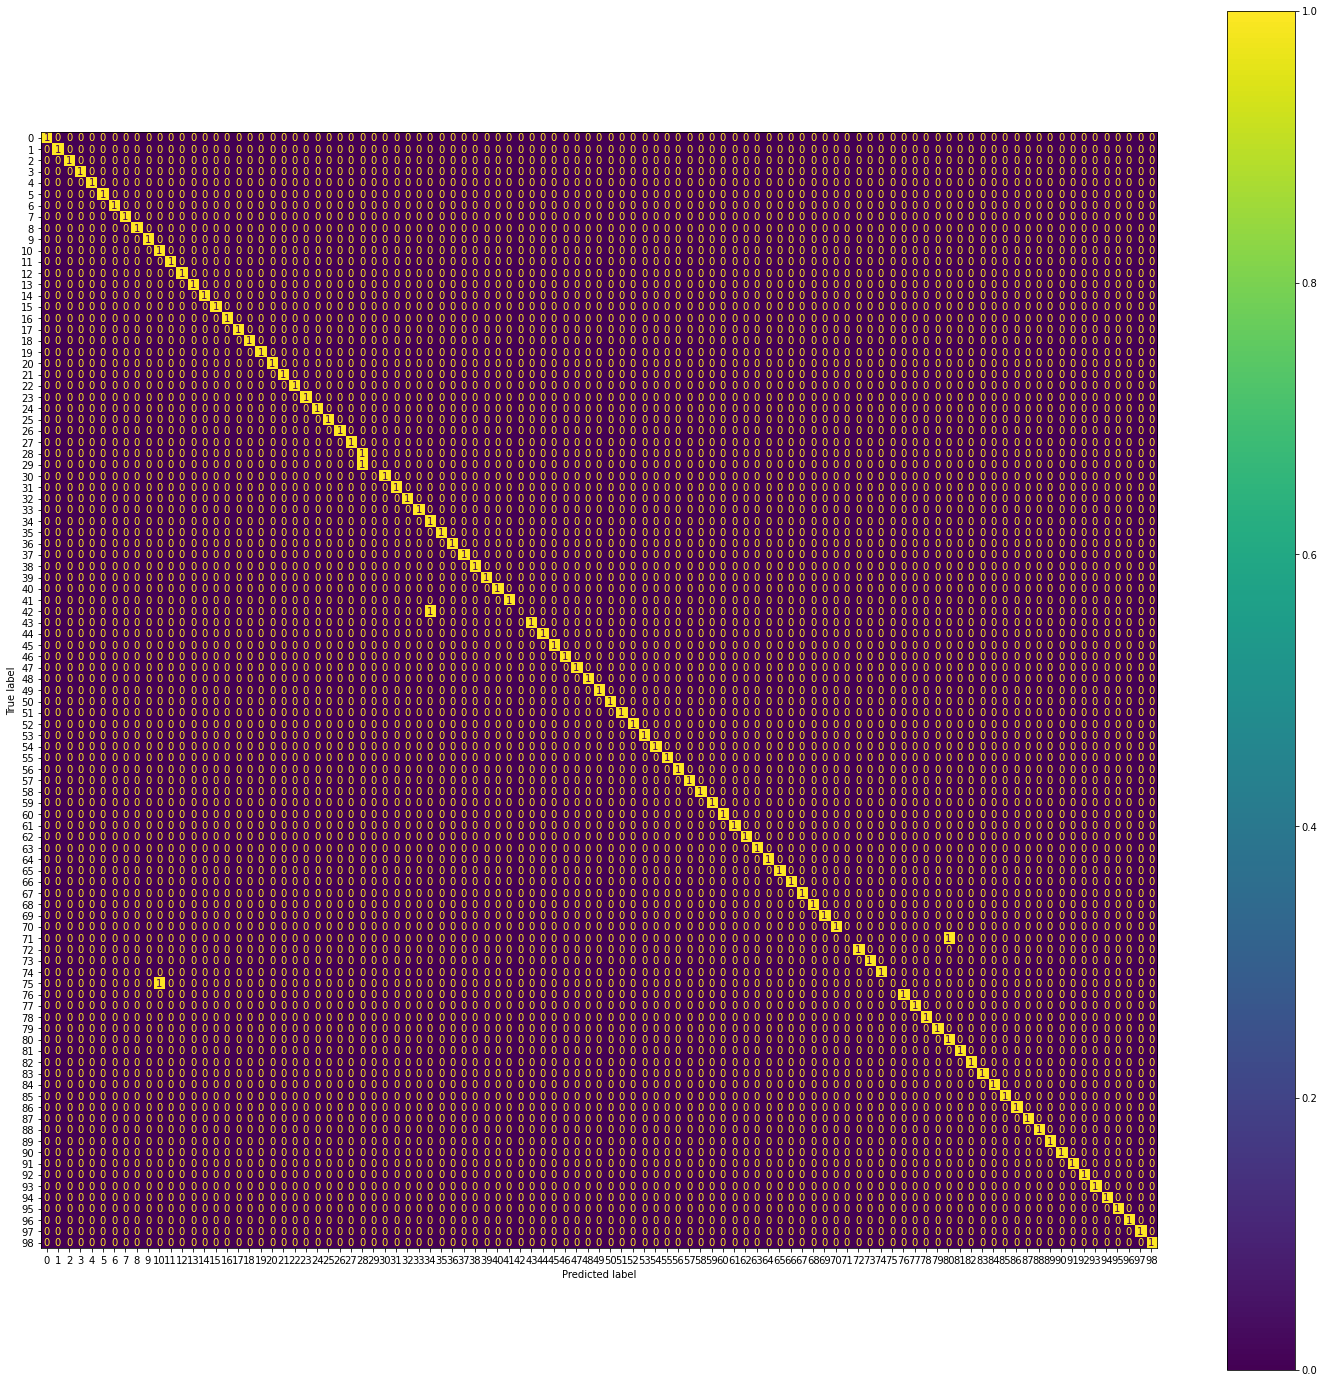

In [22]:
# Let us look at the Multi-Class Confusion Matrix 
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, confusion_matrix


y_test_pred = np.argmax(model_1.predict(X_test_r), axis=-1)
y_test_max = np.argmax(y_test, axis=-1)


cm_mat = confusion_matrix(y_test_max, y_test_pred)
cmd = ConfusionMatrixDisplay(cm_mat)

fig, ax = plt.subplots(figsize=(25,25))
cmd.plot(ax=ax)


In [ ]:
# Let's see how it does with the Test Data 

In [23]:
scaler = StandardScaler().fit(test_data.values)
scaled_test = scaler.transform(test_data.values)

In [24]:
test_dataset = np.zeros((len(scaled_test), nb_features, 3))
test_dataset[:, :, 0] = scaled_test[:, :nb_features]
test_dataset[:, :, 1] = scaled_test[:, nb_features:128]
test_dataset[:, :, 2] = scaled_test[:, 128:]

In [25]:
preds_test = model_1.predict(test_dataset)

preds_test

array([[7.5969530e-07, 5.4071747e-06, 2.6744195e-07, ..., 2.3255122e-08,
        1.9251765e-04, 1.5369013e-06],
       [1.4514354e-05, 1.9698291e-06, 7.6609416e-05, ..., 1.1636409e-04,
        2.9481950e-07, 7.7707344e-05],
       [3.9112361e-05, 9.4305348e-01, 1.1023466e-06, ..., 5.4209380e-08,
        1.0037496e-06, 5.3276243e-03],
       ...,
       [2.7365313e-04, 1.7515727e-05, 2.9262703e-06, ..., 5.9098949e-07,
        4.3249383e-07, 2.3290935e-04],
       [4.9053433e-06, 4.1321673e-06, 8.7299809e-04, ..., 2.1254577e-04,
        1.6713506e-07, 1.2754490e-04],
       [6.0390846e-07, 7.7814402e-06, 4.3796541e-04, ..., 6.2519168e-05,
        1.9712691e-06, 9.4330208e-05]], dtype=float32)

In [26]:
# Kaggle submission 

submission = pd.DataFrame(preds_test, columns=classes)
submission.insert(0, 'id', test_ids)
submission

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
0,4,7.596953e-07,0.000005,2.674419e-07,0.000001,5.481222e-06,4.979240e-05,2.339744e-07,4.190993e-07,9.456609e-07,...,3.963879e-09,1.623910e-05,1.221158e-05,1.613266e-06,2.134038e-05,1.646456e-07,5.215693e-08,2.325512e-08,1.925176e-04,0.000002
1,7,1.451435e-05,0.000002,7.660942e-05,0.007280,3.292530e-07,3.225886e-05,1.221902e-03,9.089450e-07,1.378473e-05,...,2.532391e-05,8.753134e-05,6.863786e-07,5.140366e-07,3.921537e-07,2.559540e-04,2.865625e-06,1.163641e-04,2.948195e-07,0.000078
2,9,3.911236e-05,0.943053,1.102347e-06,0.000021,4.488905e-03,2.811733e-05,2.704009e-05,9.389827e-05,5.314922e-03,...,2.004429e-05,1.445015e-06,5.869576e-06,2.872240e-06,1.231456e-05,4.843897e-05,4.768877e-05,5.420938e-08,1.003750e-06,0.005328
3,12,2.058629e-05,0.050799,6.050191e-07,0.000105,1.369525e-06,8.283719e-07,3.607814e-04,1.378357e-04,2.333503e-03,...,2.803263e-04,8.442180e-07,3.388083e-05,4.980868e-07,4.632736e-05,3.804877e-03,3.822683e-02,1.031286e-07,6.609265e-07,0.005422
4,13,4.012387e-05,0.001117,4.016308e-08,0.000002,2.350231e-06,7.023882e-07,2.413956e-05,1.094571e-04,3.001197e-02,...,4.380924e-05,9.387146e-08,2.559801e-04,3.050311e-06,3.649476e-04,6.882927e-04,3.116967e-03,8.550909e-08,2.992223e-06,0.000092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,1576,5.490537e-05,0.974025,8.078181e-07,0.000012,8.372069e-04,4.261320e-06,1.071739e-05,3.501425e-05,3.638434e-03,...,1.606669e-05,1.398963e-06,3.903417e-06,1.051376e-06,5.644196e-06,5.584707e-05,6.961438e-05,4.026883e-08,5.475900e-07,0.002155
590,1577,1.181566e-03,0.000266,7.720414e-07,0.000403,3.387019e-06,2.230717e-06,3.498167e-05,1.864859e-03,7.878271e-03,...,3.834580e-05,1.918444e-06,7.733735e-04,9.053463e-06,2.177284e-03,5.079826e-03,4.034097e-04,2.884165e-07,1.664944e-06,0.000874
591,1579,2.736531e-04,0.000018,2.926270e-06,0.000001,2.347389e-05,1.385458e-04,2.200371e-06,5.430390e-06,9.120378e-06,...,1.937802e-08,1.129869e-06,1.193599e-05,8.394958e-06,9.034533e-05,1.417739e-07,8.993813e-08,5.909895e-07,4.324938e-07,0.000233
592,1580,4.905343e-06,0.000004,8.729981e-04,0.001521,1.135731e-05,5.222543e-06,1.431581e-04,1.115879e-04,4.123242e-05,...,1.446797e-04,1.828396e-04,4.016135e-07,8.854609e-04,7.365278e-07,1.254966e-04,2.904001e-06,2.125458e-04,1.671351e-07,0.000128


In [27]:
print( submission.head() )


   id  Acer_Capillipes  Acer_Circinatum     Acer_Mono  Acer_Opalus  \
0   4     7.596953e-07         0.000005  2.674419e-07     0.000001   
1   7     1.451435e-05         0.000002  7.660942e-05     0.007280   
2   9     3.911236e-05         0.943053  1.102347e-06     0.000021   
3  12     2.058629e-05         0.050799  6.050191e-07     0.000105   
4  13     4.012387e-05         0.001117  4.016308e-08     0.000002   

   Acer_Palmatum   Acer_Pictum  Acer_Platanoids   Acer_Rubrum  Acer_Rufinerve  \
0   5.481222e-06  4.979240e-05     2.339744e-07  4.190993e-07    9.456609e-07   
1   3.292530e-07  3.225886e-05     1.221902e-03  9.089450e-07    1.378473e-05   
2   4.488905e-03  2.811733e-05     2.704009e-05  9.389827e-05    5.314922e-03   
3   1.369525e-06  8.283719e-07     3.607814e-04  1.378357e-04    2.333503e-03   
4   2.350231e-06  7.023882e-07     2.413956e-05  1.094571e-04    3.001197e-02   

   ...  Salix_Fragilis  Salix_Intergra   Sorbus_Aria  Tilia_Oliveri  \
0  ...    3.963879e-0

In [28]:
submission.to_csv('submission_CNN_1.csv', index=False)
print('done!')

done!


In [29]:
# Now we will try with the Image files and 2D CNN
# We wll resize image to 96x96 matrix

import os

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

# If you want to use Theano, all you need to change
# is the dim ordering whenever you are dealing with
# the image array. Instead of
# (samples, rows, cols, channels) it should be
# (samples, channels, rows, cols)

# Keras stuff
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import img_to_array, load_img

# A large amount of the data loading code is based on najeebkhan's kernel
# Check it out at https://www.kaggle.com/najeebkhan/leaf-classification/neural-network-through-keras
root = './'
np.random.seed(2016)
split_random_state = 7
split = .9


def load_numeric_training(standardize=True):
    """
    Loads the pre-extracted features for the training data
    and returns a tuple of the image ids, the data, and the labels
    """
    # Read data from the CSV file
    data = pd.read_csv(os.path.join(root, 'train.csv.zip'))
    ID = data.pop('id')

    # Since the labels are textual, so we encode them categorically
    y = data.pop('species')
    y = LabelEncoder().fit(y).transform(y)
    # standardize the data by setting the mean to 0 and std to 1
    X = StandardScaler().fit(data).transform(data) if standardize else data.values

    return ID, X, y


def load_numeric_test(standardize=True):
    """
    Loads the pre-extracted features for the test data
    and returns a tuple of the image ids, the data
    """
    test = pd.read_csv(os.path.join(root, 'test.csv.zip'))
    ID = test.pop('id')
    # standardize the data by setting the mean to 0 and std to 1
    test = StandardScaler().fit(test).transform(test) if standardize else test.values
    return ID, test


def resize_img(img, max_dim=96):
    """
    Resize the image to so the maximum side is of size max_dim
    Returns a new image of the right size
    """
    # Get the axis with the larger dimension
    max_ax = max((0, 1), key=lambda i: img.size[i])
    # Scale both axes so the image's largest dimension is max_dim
    scale = max_dim / float(img.size[max_ax])
    return img.resize((int(img.size[0] * scale), int(img.size[1] * scale)))


def load_image_data(ids, max_dim=96, center=True):
    """
    Takes as input an array of image ids and loads the images as numpy
    arrays with the images resized so the longest side is max-dim length.
    If center is True, then will place the image in the center of
    the output array, otherwise it will be placed at the top-left corner.
    """
    # Initialize the output array
    # NOTE: Theano users comment line below and
    X = np.empty((len(ids), max_dim, max_dim, 1))
    # X = np.empty((len(ids), 1, max_dim, max_dim)) # uncomment this
    for i, idee in enumerate(ids):
        # Turn the image into an array
        x = resize_img(load_img(os.path.join(root, 'images', str(idee) + '.jpg'), grayscale=True), max_dim=max_dim)
        x = img_to_array(x)
        # Get the corners of the bounding box for the image
        # NOTE: Theano users comment the two lines below and
        length = x.shape[0]
        width = x.shape[1]
        # length = x.shape[1] # uncomment this
        # width = x.shape[2] # uncomment this
        if center:
            h1 = int((max_dim - length) / 2)
            h2 = h1 + length
            w1 = int((max_dim - width) / 2)
            w2 = w1 + width
        else:
            h1, w1 = 0, 0
            h2, w2 = (length, width)
        # Insert into image matrix
        # NOTE: Theano users comment line below and
        X[i, h1:h2, w1:w2, 0:1] = x
        # X[i, 0:1, h1:h2, w1:w2] = x  # uncomment this
    # Scale the array values so they are between 0 and 1
    return np.around(X / 255.0)


def load_train_data(split=split, random_state=None):
    """
    Loads the pre-extracted feature and image training data and
    splits them into training and cross-validation.
    Returns one tuple for the training data and one for the validation
    data. Each tuple is in the order pre-extracted features, images,
    and labels.
    """
    # Load the pre-extracted features
    ID, X_num_tr, y = load_numeric_training()
    # Load the image data
    X_img_tr = load_image_data(ID)
    # Split them into validation and cross-validation
    sss = StratifiedShuffleSplit(n_splits=1, train_size=split, random_state=random_state)
    train_ind, test_ind = next(sss.split(X_num_tr, y))
    X_num_val, X_img_val, y_val = X_num_tr[test_ind], X_img_tr[test_ind], y[test_ind]
    X_num_tr, X_img_tr, y_tr = X_num_tr[train_ind], X_img_tr[train_ind], y[train_ind]
    return (X_num_tr, X_img_tr, y_tr), (X_num_val, X_img_val, y_val)


def load_test_data():
    """
    Loads the pre-extracted feature and image test data.
    Returns a tuple in the order ids, pre-extracted features,
    and images.
    """
    # Load the pre-extracted features
    ID, X_num_te = load_numeric_test()
    # Load the image data
    X_img_te = load_image_data(ID)
    return ID, X_num_te, X_img_te

print('Loading the training data...')
(X_num_tr, X_img_tr, y_tr), (X_num_val, X_img_val, y_val) = load_train_data(random_state=split_random_state)
y_tr_cat = to_categorical(y_tr)
y_val_cat = to_categorical(y_val)
print('Training data loaded!')


Loading the training data...


/usr/local/lib/python3.8/site-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Training data loaded!


Let us create a 2D CNN with 2 Convolution layers, 7x7, 5x5 and two Dense connected layers with Maxpooling 

In [43]:
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Convolution2D, MaxPooling2D, Flatten, Input, merge


def create_model_2():

    # Define the image input
    image = Input(shape=(96, 96, 1), name='image')
    # Pass it through the first convolutional layer
    x = Convolution2D(16, 7, 7, input_shape=(96, 96, 1), padding='SAME')(image)
    x = (Activation('relu'))(x)
    x = (MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))(x)

    # Now through the second convolutional layer
    x = (Convolution2D(64, 5, 5, padding='SAME'))(x)
    x = (Activation('relu'))(x)
    x = (MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))(x)

    # Flatten our array
    x = Flatten()(x)
    # Define the pre-extracted feature input
    #numerical = Input(shape=(192,), name='numerical')
    # Concatenate the output of our convnet with our pre-extracted feature input
    #concatenated = merge([x, numerical], mode='concat')
    #concatenated = keras.layers.Concatenate()([x, numerical])

    # Add a fully connected layer just like in a normal MLP
    x = Dense(100, activation='relu')(x)
    x = Dropout(.5)(x)

    # Get the final output
    out = Dense(99, activation='softmax')(x)
    # How we create models with the Functional API
    #model = Model(input=[image, numerical], output=out)
    
    model = Model(inputs=[image], outputs=[out])


    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

    return model

print('Creating the model...')
model_2 = create_model_2()
print('Model created!')


Creating the model...
Model created!


In [44]:

# Initialize callbacks and fit the model 
# Here we are using a 20% Validation data set 
cb1 = EarlyStopping(patience = 3, restore_best_weights=True, monitor = 'val_acc')
cb2 = ReduceLROnPlateau(patience = 4, min_lr=0.00001, factor = 0.4, monitor = 'val_acc')


#history = model_2.fit(X_img_tr, y_tr_cat, epochs=nb_epoch, validation_data=(X_img_val, y_val_cat), batch_size=16)

history = model_2.fit(X_img_tr, y_tr_cat, validation_split=0.2, epochs = 100, batch_size = 32, callbacks = [cb1, cb2], verbose = 1)



Epoch 1/100
23/23 [==============================] - 1s 12ms/step - loss: 4.5881 - accuracy: 0.0183 - val_loss: 4.5776 - val_accuracy: 0.0168 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 0s 6ms/step - loss: 4.5004 - accuracy: 0.0323 - val_loss: 4.4312 - val_accuracy: 0.0391 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 0s 6ms/step - loss: 4.2971 - accuracy: 0.0407 - val_loss: 4.2170 - val_accuracy: 0.0447 - lr: 0.0010
Epoch 4/100
23/23 [==============================] - 0s 6ms/step - loss: 4.0823 - accuracy: 0.0520 - val_loss: 4.0021 - val_accuracy: 0.0726 - lr: 0.0010
Epoch 5/100
23/23 [==============================] - 0s 5ms/step - loss: 3.9250 - accuracy: 0.0660 - val_loss: 3.8584 - val_accuracy: 0.0894 - lr: 0.0010
Epoch 6/100
23/23 [==============================] - 0s 6ms/step - loss: 3.7448 - accuracy: 0.0758 - val_loss: 3.6636 - val_accuracy: 0.0950 - lr: 0.0010
Epoch 7/100
23/23 [==============================] - 0s 6ms/step - loss: 3.

Epoch 16/100
23/23 [==============================] - 0s 6ms/step - loss: 2.4611 - accuracy: 0.2893 - val_loss: 2.4441 - val_accuracy: 0.2737 - lr: 0.0010
Epoch 17/100
23/23 [==============================] - 0s 6ms/step - loss: 2.3534 - accuracy: 0.3202 - val_loss: 2.3732 - val_accuracy: 0.3128 - lr: 0.0010
Epoch 18/100
23/23 [==============================] - 0s 6ms/step - loss: 2.2630 - accuracy: 0.3610 - val_loss: 2.2613 - val_accuracy: 0.3687 - lr: 0.0010
Epoch 19/100
23/23 [==============================] - 0s 6ms/step - loss: 2.2179 - accuracy: 0.3806 - val_loss: 2.2912 - val_accuracy: 0.3240 - lr: 0.0010
Epoch 20/100
23/23 [==============================] - 0s 6ms/step - loss: 2.1558 - accuracy: 0.3581 - val_loss: 2.1749 - val_accuracy: 0.3799 - lr: 0.0010
Epoch 21/100
23/23 [==============================] - 0s 6ms/step - loss: 2.2288 - accuracy: 0.3483 - val_loss: 2.0846 - val_accuracy: 0.3911 - lr: 0.0010
Epoch 22/100
23/23 [==============================] - 0s 6ms/step - lo

Epoch 31/100
23/23 [==============================] - 0s 6ms/step - loss: 1.6735 - accuracy: 0.4972 - val_loss: 1.8435 - val_accuracy: 0.4749 - lr: 0.0010
Epoch 32/100
23/23 [==============================] - 0s 6ms/step - loss: 1.5937 - accuracy: 0.4916 - val_loss: 1.8170 - val_accuracy: 0.4804 - lr: 0.0010
Epoch 33/100
23/23 [==============================] - 0s 6ms/step - loss: 1.5532 - accuracy: 0.5154 - val_loss: 1.8713 - val_accuracy: 0.4246 - lr: 0.0010
Epoch 34/100
23/23 [==============================] - 0s 6ms/step - loss: 1.4814 - accuracy: 0.5562 - val_loss: 1.7458 - val_accuracy: 0.4581 - lr: 0.0010
Epoch 35/100
23/23 [==============================] - 0s 6ms/step - loss: 1.5038 - accuracy: 0.5351 - val_loss: 1.7842 - val_accuracy: 0.4804 - lr: 0.0010
Epoch 36/100
23/23 [==============================] - 0s 5ms/step - loss: 1.4650 - accuracy: 0.5492 - val_loss: 1.7977 - val_accuracy: 0.4749 - lr: 0.0010
Epoch 37/100
23/23 [==============================] - 0s 6ms/step - lo

Epoch 46/100
23/23 [==============================] - 0s 5ms/step - loss: 1.1844 - accuracy: 0.6081 - val_loss: 1.8169 - val_accuracy: 0.4860 - lr: 0.0010
Epoch 47/100
23/23 [==============================] - 0s 5ms/step - loss: 1.1540 - accuracy: 0.6306 - val_loss: 1.7004 - val_accuracy: 0.5028 - lr: 0.0010
Epoch 48/100
23/23 [==============================] - 0s 5ms/step - loss: 1.1613 - accuracy: 0.6264 - val_loss: 1.7229 - val_accuracy: 0.5307 - lr: 0.0010
Epoch 49/100
23/23 [==============================] - 0s 6ms/step - loss: 1.0997 - accuracy: 0.6517 - val_loss: 1.6968 - val_accuracy: 0.5251 - lr: 0.0010
Epoch 50/100
23/23 [==============================] - 0s 6ms/step - loss: 1.1240 - accuracy: 0.6222 - val_loss: 1.7052 - val_accuracy: 0.5140 - lr: 0.0010
Epoch 51/100
23/23 [==============================] - 0s 6ms/step - loss: 1.1123 - accuracy: 0.6404 - val_loss: 1.8034 - val_accuracy: 0.5028 - lr: 0.0010
Epoch 52/100
23/23 [==============================] - 0s 5ms/step - lo

Epoch 61/100
23/23 [==============================] - 0s 5ms/step - loss: 0.9510 - accuracy: 0.6882 - val_loss: 1.7802 - val_accuracy: 0.5307 - lr: 0.0010
Epoch 62/100
23/23 [==============================] - 0s 6ms/step - loss: 0.9668 - accuracy: 0.6671 - val_loss: 1.8217 - val_accuracy: 0.5251 - lr: 0.0010
Epoch 63/100
23/23 [==============================] - 0s 5ms/step - loss: 0.8908 - accuracy: 0.7135 - val_loss: 1.8098 - val_accuracy: 0.5419 - lr: 0.0010
Epoch 64/100
23/23 [==============================] - 0s 5ms/step - loss: 0.8689 - accuracy: 0.7093 - val_loss: 1.8502 - val_accuracy: 0.5531 - lr: 0.0010
Epoch 65/100
23/23 [==============================] - 0s 6ms/step - loss: 0.8246 - accuracy: 0.7303 - val_loss: 1.7228 - val_accuracy: 0.5307 - lr: 0.0010
Epoch 66/100
23/23 [==============================] - 0s 6ms/step - loss: 0.8396 - accuracy: 0.7261 - val_loss: 1.8136 - val_accuracy: 0.5419 - lr: 0.0010
Epoch 67/100
23/23 [==============================] - 0s 6ms/step - lo

Epoch 76/100
23/23 [==============================] - 0s 6ms/step - loss: 0.7397 - accuracy: 0.7472 - val_loss: 1.9730 - val_accuracy: 0.5251 - lr: 0.0010
Epoch 77/100
23/23 [==============================] - 0s 6ms/step - loss: 0.7608 - accuracy: 0.7275 - val_loss: 1.9525 - val_accuracy: 0.5531 - lr: 0.0010
Epoch 78/100
23/23 [==============================] - 0s 6ms/step - loss: 0.7129 - accuracy: 0.7640 - val_loss: 2.0201 - val_accuracy: 0.5363 - lr: 0.0010
Epoch 79/100
23/23 [==============================] - 0s 6ms/step - loss: 0.7187 - accuracy: 0.7402 - val_loss: 2.0277 - val_accuracy: 0.5587 - lr: 0.0010
Epoch 80/100
23/23 [==============================] - 0s 6ms/step - loss: 0.6862 - accuracy: 0.7809 - val_loss: 1.9660 - val_accuracy: 0.5475 - lr: 0.0010
Epoch 81/100
23/23 [==============================] - 0s 5ms/step - loss: 0.6645 - accuracy: 0.7626 - val_loss: 2.1445 - val_accuracy: 0.5307 - lr: 0.0010
Epoch 82/100
23/23 [==============================] - 0s 5ms/step - lo

Epoch 91/100
23/23 [==============================] - 0s 6ms/step - loss: 0.5848 - accuracy: 0.8062 - val_loss: 2.0052 - val_accuracy: 0.5363 - lr: 0.0010
Epoch 92/100
23/23 [==============================] - 0s 6ms/step - loss: 0.6134 - accuracy: 0.7921 - val_loss: 1.9064 - val_accuracy: 0.5754 - lr: 0.0010
Epoch 93/100
23/23 [==============================] - 0s 6ms/step - loss: 0.5885 - accuracy: 0.8020 - val_loss: 1.8856 - val_accuracy: 0.5587 - lr: 0.0010
Epoch 94/100
23/23 [==============================] - 0s 5ms/step - loss: 0.6231 - accuracy: 0.7683 - val_loss: 2.0606 - val_accuracy: 0.5642 - lr: 0.0010
Epoch 95/100
23/23 [==============================] - 0s 5ms/step - loss: 0.5846 - accuracy: 0.8006 - val_loss: 2.2107 - val_accuracy: 0.5419 - lr: 0.0010
Epoch 96/100
23/23 [==============================] - 0s 6ms/step - loss: 0.5571 - accuracy: 0.8118 - val_loss: 2.0001 - val_accuracy: 0.5642 - lr: 0.0010
Epoch 97/100
23/23 [==============================] - 0s 6ms/step - lo

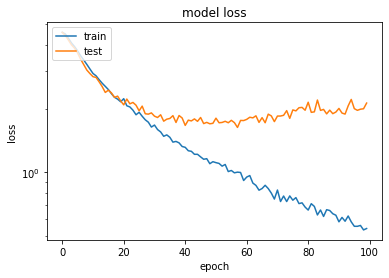

In [45]:
## summarize history for loss
## Plotting the loss with the number of iterations
plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

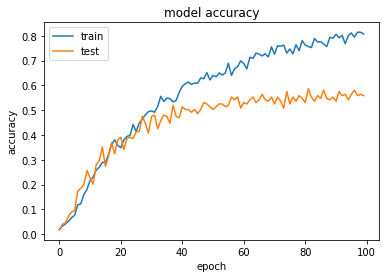

In [46]:
## Plotting the error with the number of iterations
## With each iteration the error reduces smoothly
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

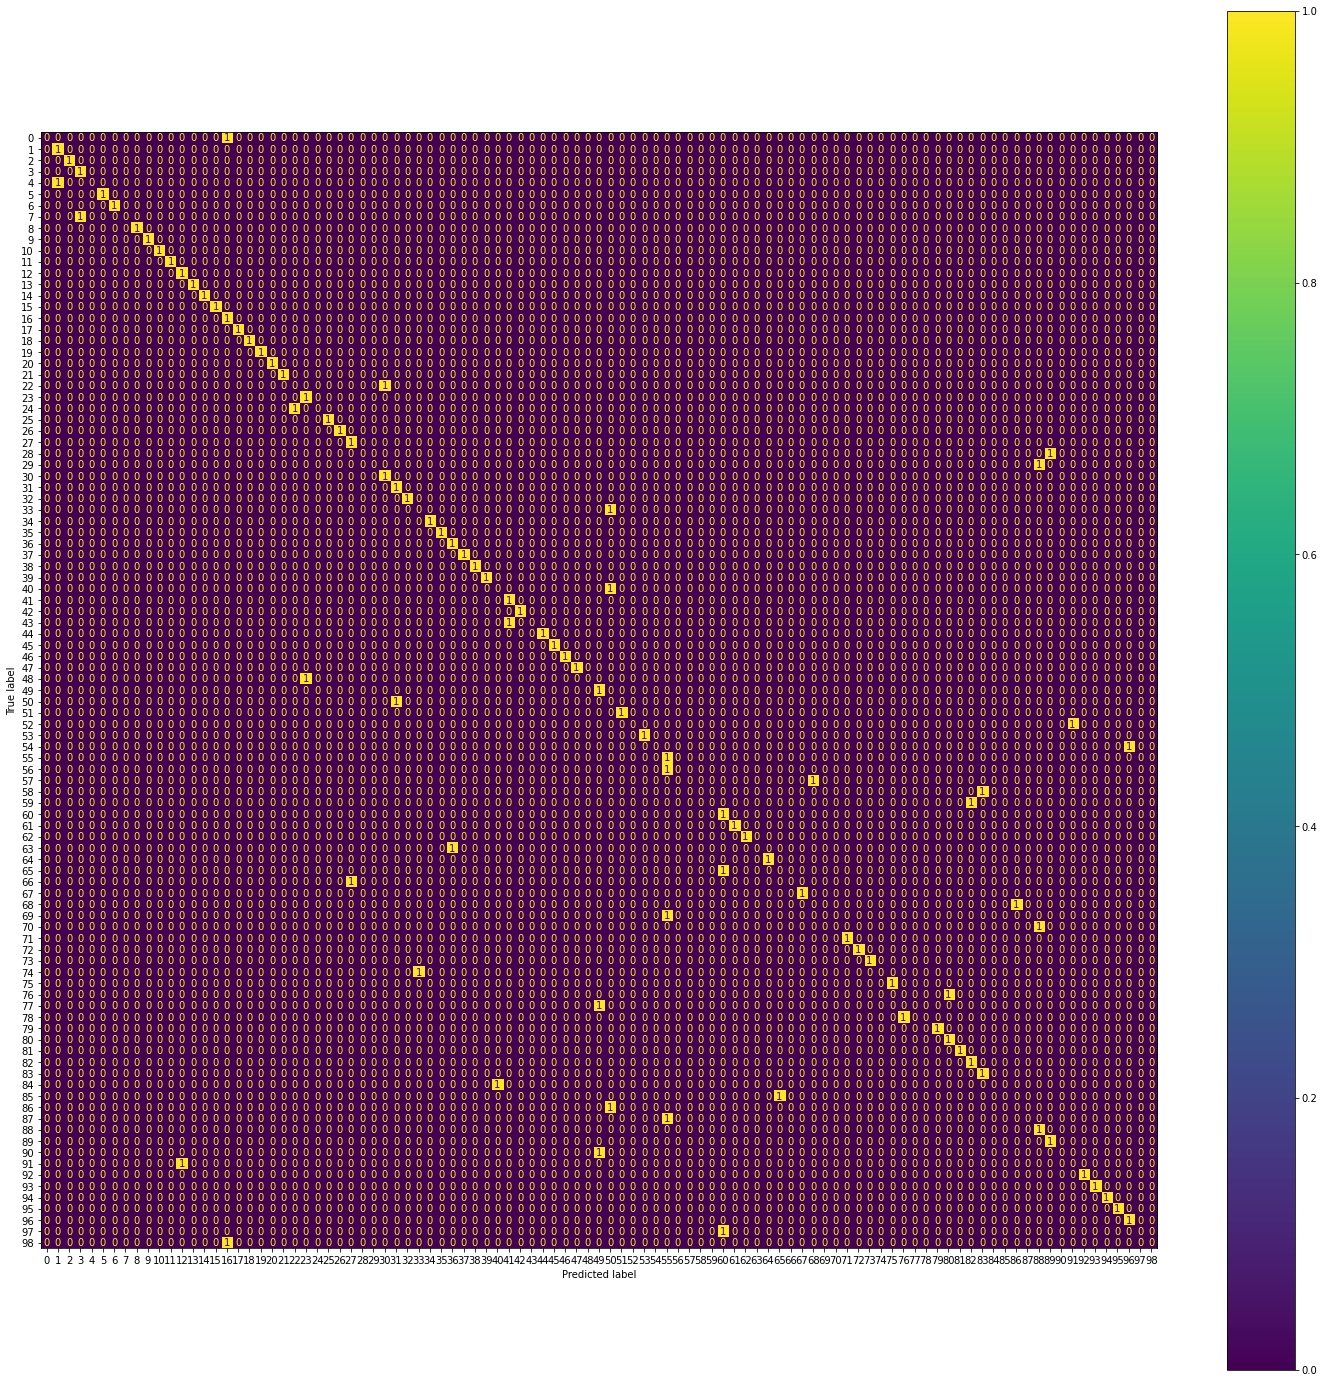

In [48]:
# MultiClass Confusion Matrix plot 

y_test_pred = np.argmax(model_2.predict(X_img_val), axis=-1)
y_test_max = np.argmax(y_val_cat, axis=-1)

#X_img_val, y_val_cat

cm_mat = confusion_matrix(y_test_max, y_test_pred)
cmd = ConfusionMatrixDisplay(cm_mat)

fig, ax = plt.subplots(figsize=(25,25))
cmd.plot(ax=ax)



Let us do some EDA

In [51]:
# Let us do some tweaking to the CNN on leave pictures and see the model performance, accuracy might improve 

from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Convolution2D, MaxPooling2D, Flatten, Input, merge


def build_model_3():

    # Define the image input
    image = Input(shape=(96, 96, 1), name='image')
    # Pass it through the first convolutional layer
    x = Convolution2D(32, 7, 7, input_shape=(96, 96, 1), padding='SAME')(image)
    x = (Activation('relu'))(x)
    x = (MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))(x)

    # Now through the second convolutional layer
    x = (Convolution2D(64, 5, 5, padding='SAME'))(x)
    x = (Activation('relu'))(x)
    x = (MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))(x)
    
    # Now through the Third convolutional layer
    #x = (Convolution2D(128, 5, 5, padding='SAME'))(x)
    #x = (Activation('relu'))(x)
    #x = (MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))(x)

    # Flatten our array
    x = Flatten()(x)

    # Add a fully connected layer just like in a normal MLP
    x = Dense(128, activation='relu')(x)
    x = Dropout(.5)(x)

    # Get the final output
    out = Dense(99, activation='softmax')(x)
    # How we create models with the Functional API
    #model = Model(input=[image, numerical], output=out)
    
    model = Model(inputs=[image], outputs=[out])


    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])

    return model

print('Creating the model...')
model_3 = build_model_3()
print('Model 3 created!')


Creating the model...
Model 3 created!


In [53]:



# Initialize callbacks
cb1 = EarlyStopping(patience = 3, restore_best_weights=True, monitor = 'val_acc')
cb2 = ReduceLROnPlateau(patience = 4, min_lr=0.00001, factor = 0.4, monitor = 'val_acc')


history_3 = model_3.fit(X_img_tr, y_tr_cat, validation_split=0.2, epochs = 100, batch_size = 32, callbacks = [cb1, cb2], verbose = 1)



Epoch 1/100
23/23 [==============================] - 0s 8ms/step - loss: 0.4891 - accuracy: 0.8455 - val_loss: 1.8162 - val_accuracy: 0.5642 - lr: 5.0000e-04
Epoch 2/100
23/23 [==============================] - 0s 6ms/step - loss: 0.4844 - accuracy: 0.8301 - val_loss: 1.7540 - val_accuracy: 0.5642 - lr: 5.0000e-04
Epoch 3/100
23/23 [==============================] - 0s 6ms/step - loss: 0.4626 - accuracy: 0.8413 - val_loss: 1.8035 - val_accuracy: 0.5698 - lr: 5.0000e-04
Epoch 4/100
23/23 [==============================] - 0s 6ms/step - loss: 0.4616 - accuracy: 0.8357 - val_loss: 1.7921 - val_accuracy: 0.5475 - lr: 5.0000e-04
Epoch 5/100
23/23 [==============================] - 0s 6ms/step - loss: 0.4501 - accuracy: 0.8469 - val_loss: 1.7368 - val_accuracy: 0.5978 - lr: 5.0000e-04
Epoch 6/100
23/23 [==============================] - 0s 6ms/step - loss: 0.4912 - accuracy: 0.8216 - val_loss: 1.7849 - val_accuracy: 0.5810 - lr: 5.0000e-04
Epoch 7/100
23/23 [==============================] -

Epoch 16/100
23/23 [==============================] - 0s 6ms/step - loss: 0.4175 - accuracy: 0.8385 - val_loss: 1.8421 - val_accuracy: 0.5754 - lr: 5.0000e-04
Epoch 17/100
23/23 [==============================] - 0s 7ms/step - loss: 0.3902 - accuracy: 0.8652 - val_loss: 1.8016 - val_accuracy: 0.5754 - lr: 5.0000e-04
Epoch 18/100
23/23 [==============================] - 0s 7ms/step - loss: 0.3800 - accuracy: 0.8708 - val_loss: 1.7814 - val_accuracy: 0.5698 - lr: 5.0000e-04
Epoch 19/100
23/23 [==============================] - 0s 6ms/step - loss: 0.4028 - accuracy: 0.8624 - val_loss: 1.9037 - val_accuracy: 0.5978 - lr: 5.0000e-04
Epoch 20/100
23/23 [==============================] - 0s 6ms/step - loss: 0.3728 - accuracy: 0.8567 - val_loss: 1.8452 - val_accuracy: 0.5698 - lr: 5.0000e-04
Epoch 21/100
23/23 [==============================] - 0s 6ms/step - loss: 0.3742 - accuracy: 0.8778 - val_loss: 1.9090 - val_accuracy: 0.5810 - lr: 5.0000e-04
Epoch 22/100
23/23 [==========================

Epoch 31/100
23/23 [==============================] - 0s 6ms/step - loss: 0.3174 - accuracy: 0.8933 - val_loss: 1.9277 - val_accuracy: 0.5810 - lr: 5.0000e-04
Epoch 32/100
23/23 [==============================] - 0s 6ms/step - loss: 0.3144 - accuracy: 0.8961 - val_loss: 1.9453 - val_accuracy: 0.5866 - lr: 5.0000e-04
Epoch 33/100
23/23 [==============================] - 0s 7ms/step - loss: 0.3273 - accuracy: 0.8919 - val_loss: 1.9952 - val_accuracy: 0.5419 - lr: 5.0000e-04
Epoch 34/100
23/23 [==============================] - 0s 6ms/step - loss: 0.3031 - accuracy: 0.8989 - val_loss: 1.9931 - val_accuracy: 0.5531 - lr: 5.0000e-04
Epoch 35/100
23/23 [==============================] - 0s 6ms/step - loss: 0.3122 - accuracy: 0.8947 - val_loss: 2.0408 - val_accuracy: 0.5754 - lr: 5.0000e-04
Epoch 36/100
23/23 [==============================] - 0s 6ms/step - loss: 0.3336 - accuracy: 0.8876 - val_loss: 1.8689 - val_accuracy: 0.5419 - lr: 5.0000e-04
Epoch 37/100
23/23 [==========================

Epoch 46/100
23/23 [==============================] - 0s 6ms/step - loss: 0.3023 - accuracy: 0.8961 - val_loss: 1.9731 - val_accuracy: 0.5754 - lr: 5.0000e-04
Epoch 47/100
23/23 [==============================] - 0s 6ms/step - loss: 0.3066 - accuracy: 0.8876 - val_loss: 1.9662 - val_accuracy: 0.5531 - lr: 5.0000e-04
Epoch 48/100
23/23 [==============================] - 0s 7ms/step - loss: 0.2564 - accuracy: 0.9101 - val_loss: 2.0296 - val_accuracy: 0.5642 - lr: 5.0000e-04
Epoch 49/100
23/23 [==============================] - 0s 6ms/step - loss: 0.2893 - accuracy: 0.9003 - val_loss: 1.9846 - val_accuracy: 0.5866 - lr: 5.0000e-04
Epoch 50/100
23/23 [==============================] - 0s 6ms/step - loss: 0.2793 - accuracy: 0.8848 - val_loss: 2.1554 - val_accuracy: 0.5642 - lr: 5.0000e-04
Epoch 51/100
23/23 [==============================] - 0s 6ms/step - loss: 0.3011 - accuracy: 0.8919 - val_loss: 1.9675 - val_accuracy: 0.5866 - lr: 5.0000e-04
Epoch 52/100
23/23 [==========================

Epoch 61/100
23/23 [==============================] - 0s 6ms/step - loss: 0.2459 - accuracy: 0.9143 - val_loss: 2.1405 - val_accuracy: 0.5475 - lr: 5.0000e-04
Epoch 62/100
23/23 [==============================] - 0s 6ms/step - loss: 0.2461 - accuracy: 0.9256 - val_loss: 2.1093 - val_accuracy: 0.5587 - lr: 5.0000e-04
Epoch 63/100
23/23 [==============================] - 0s 6ms/step - loss: 0.2300 - accuracy: 0.9185 - val_loss: 2.1661 - val_accuracy: 0.5698 - lr: 5.0000e-04
Epoch 64/100
23/23 [==============================] - 0s 6ms/step - loss: 0.2474 - accuracy: 0.9157 - val_loss: 2.1877 - val_accuracy: 0.5978 - lr: 5.0000e-04
Epoch 65/100
23/23 [==============================] - 0s 6ms/step - loss: 0.2088 - accuracy: 0.9256 - val_loss: 2.1412 - val_accuracy: 0.5866 - lr: 5.0000e-04
Epoch 66/100
23/23 [==============================] - 0s 7ms/step - loss: 0.2149 - accuracy: 0.9270 - val_loss: 2.1863 - val_accuracy: 0.5698 - lr: 5.0000e-04
Epoch 67/100
23/23 [==========================

Epoch 76/100
23/23 [==============================] - 0s 6ms/step - loss: 0.1972 - accuracy: 0.9382 - val_loss: 2.1733 - val_accuracy: 0.5698 - lr: 5.0000e-04
Epoch 77/100
23/23 [==============================] - 0s 6ms/step - loss: 0.2383 - accuracy: 0.9213 - val_loss: 2.2279 - val_accuracy: 0.5419 - lr: 5.0000e-04
Epoch 78/100
23/23 [==============================] - 0s 6ms/step - loss: 0.2091 - accuracy: 0.9368 - val_loss: 2.2139 - val_accuracy: 0.5587 - lr: 5.0000e-04
Epoch 79/100
23/23 [==============================] - 0s 6ms/step - loss: 0.2230 - accuracy: 0.9298 - val_loss: 2.2640 - val_accuracy: 0.5587 - lr: 5.0000e-04
Epoch 80/100
23/23 [==============================] - 0s 6ms/step - loss: 0.2208 - accuracy: 0.9354 - val_loss: 2.3138 - val_accuracy: 0.5642 - lr: 5.0000e-04
Epoch 81/100
23/23 [==============================] - 0s 6ms/step - loss: 0.1806 - accuracy: 0.9452 - val_loss: 2.2493 - val_accuracy: 0.5698 - lr: 5.0000e-04
Epoch 82/100
23/23 [==========================

Epoch 91/100
23/23 [==============================] - 0s 6ms/step - loss: 0.1721 - accuracy: 0.9410 - val_loss: 2.3288 - val_accuracy: 0.5698 - lr: 5.0000e-04
Epoch 92/100
23/23 [==============================] - 0s 6ms/step - loss: 0.2136 - accuracy: 0.9228 - val_loss: 2.3541 - val_accuracy: 0.5810 - lr: 5.0000e-04
Epoch 93/100
23/23 [==============================] - 0s 7ms/step - loss: 0.1696 - accuracy: 0.9410 - val_loss: 2.3190 - val_accuracy: 0.5922 - lr: 5.0000e-04
Epoch 94/100
23/23 [==============================] - 0s 7ms/step - loss: 0.1906 - accuracy: 0.9340 - val_loss: 2.3321 - val_accuracy: 0.5698 - lr: 5.0000e-04
Epoch 95/100
23/23 [==============================] - 0s 6ms/step - loss: 0.1948 - accuracy: 0.9410 - val_loss: 2.3336 - val_accuracy: 0.5754 - lr: 5.0000e-04
Epoch 96/100
23/23 [==============================] - 0s 6ms/step - loss: 0.1695 - accuracy: 0.9466 - val_loss: 2.3331 - val_accuracy: 0.5698 - lr: 5.0000e-04
Epoch 97/100
23/23 [==========================

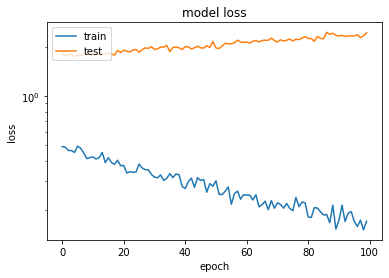

In [54]:
## summarize history for loss
## Plotting the loss with the number of iterations
plt.semilogy(history_3.history['loss'])
plt.semilogy(history_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

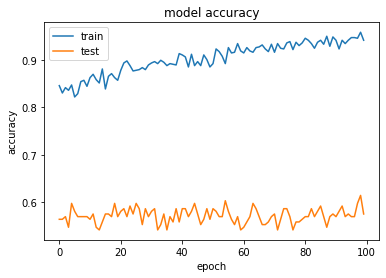

In [55]:
## Plotting the error with the number of iterations
## With each iteration the error reduces smoothly
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [58]:
# Model 4 and Kaggle Submission with test set provided

model_4 = Sequential()
model_4.add(Convolution1D(512, 1, input_shape=(nb_features, 3)))
model_4.add(Activation('relu'))
model_4.add(Flatten())
model_4.add(Dropout(0.4))
model_4.add(Dense(2048, activation='relu'))
model_4.add(Dense(1024, activation='relu'))
model_4.add(Dense(nb_class))
model_4.add(Activation('softmax'))

In [59]:
# Compile the Model 4 

model_4.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

cb1 = EarlyStopping(patience = 3, restore_best_weights=True, monitor = 'val_acc')
cb2 = ReduceLROnPlateau(patience = 4, min_lr=0.00001, factor = 0.4, monitor = 'val_acc')


#model_1.fit(X_train_r, y_train, epochs=15, validation_data=(X_valid_r, y_valid), batch_size=160)
history = model_4.fit(X_train_r, y_train, epochs=80, validation_split=0.2, batch_size=160, callbacks = [cb1, cb2], verbose = 1)





Epoch 1/80
5/5 [==============================] - 4s 761ms/step - loss: 9.8920 - accuracy: 0.0337 - val_loss: 5.1007 - val_accuracy: 0.1229 - lr: 0.0010
Epoch 2/80
5/5 [==============================] - 4s 784ms/step - loss: 3.4735 - accuracy: 0.3567 - val_loss: 2.1133 - val_accuracy: 0.5475 - lr: 0.0010
Epoch 3/80
5/5 [==============================] - 4s 768ms/step - loss: 1.2652 - accuracy: 0.7191 - val_loss: 1.4678 - val_accuracy: 0.6592 - lr: 0.0010
Epoch 4/80
5/5 [==============================] - 4s 764ms/step - loss: 0.7800 - accuracy: 0.8343 - val_loss: 0.4733 - val_accuracy: 0.9050 - lr: 0.0010
Epoch 5/80
5/5 [==============================] - 4s 794ms/step - loss: 0.1405 - accuracy: 0.9803 - val_loss: 0.6122 - val_accuracy: 0.9218 - lr: 0.0010
Epoch 6/80
5/5 [==============================] - 4s 802ms/step - loss: 0.1733 - accuracy: 0.9691 - val_loss: 0.1618 - val_accuracy: 0.9665 - lr: 0.0010
Epoch 7/80
5/5 [==============================] - 4s 834ms/step - loss: 0.0932 - a

Epoch 16/80
5/5 [==============================] - 4s 833ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0580 - val_accuracy: 0.9777 - lr: 0.0010
Epoch 17/80
5/5 [==============================] - 4s 883ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0545 - val_accuracy: 0.9832 - lr: 0.0010
Epoch 18/80
5/5 [==============================] - 5s 904ms/step - loss: 6.8949e-04 - accuracy: 1.0000 - val_loss: 0.0537 - val_accuracy: 0.9832 - lr: 0.0010
Epoch 19/80
5/5 [==============================] - 5s 931ms/step - loss: 4.7391e-04 - accuracy: 1.0000 - val_loss: 0.0539 - val_accuracy: 0.9777 - lr: 0.0010
Epoch 20/80
5/5 [==============================] - 4s 863ms/step - loss: 3.5517e-04 - accuracy: 1.0000 - val_loss: 0.0513 - val_accuracy: 0.9777 - lr: 0.0010
Epoch 21/80
5/5 [==============================] - 4s 853ms/step - loss: 2.2875e-04 - accuracy: 1.0000 - val_loss: 0.0489 - val_accuracy: 0.9777 - lr: 0.0010
Epoch 22/80
5/5 [==============================] - 4s 799ms/

Epoch 31/80
5/5 [==============================] - 4s 835ms/step - loss: 1.3973e-05 - accuracy: 1.0000 - val_loss: 0.0396 - val_accuracy: 0.9777 - lr: 0.0010
Epoch 32/80
5/5 [==============================] - 4s 830ms/step - loss: 1.1551e-05 - accuracy: 1.0000 - val_loss: 0.0397 - val_accuracy: 0.9777 - lr: 0.0010
Epoch 33/80
5/5 [==============================] - 4s 806ms/step - loss: 1.0384e-05 - accuracy: 1.0000 - val_loss: 0.0407 - val_accuracy: 0.9832 - lr: 0.0010
Epoch 34/80
5/5 [==============================] - 4s 836ms/step - loss: 1.2328e-05 - accuracy: 1.0000 - val_loss: 0.1001 - val_accuracy: 0.9721 - lr: 0.0010
Epoch 35/80
5/5 [==============================] - 4s 841ms/step - loss: 2.7395 - accuracy: 0.7289 - val_loss: 0.6598 - val_accuracy: 0.8994 - lr: 0.0010
Epoch 36/80
5/5 [==============================] - 4s 830ms/step - loss: 0.1534 - accuracy: 0.9775 - val_loss: 0.0772 - val_accuracy: 0.9665 - lr: 0.0010
Epoch 37/80
5/5 [==============================] - 4s 805ms/

Epoch 46/80
5/5 [==============================] - 4s 796ms/step - loss: 5.3987e-05 - accuracy: 1.0000 - val_loss: 0.0422 - val_accuracy: 0.9888 - lr: 0.0010
Epoch 47/80
5/5 [==============================] - 4s 791ms/step - loss: 3.0258e-05 - accuracy: 1.0000 - val_loss: 0.0441 - val_accuracy: 0.9832 - lr: 0.0010
Epoch 48/80
5/5 [==============================] - 4s 802ms/step - loss: 2.3966e-05 - accuracy: 1.0000 - val_loss: 0.0417 - val_accuracy: 0.9888 - lr: 0.0010
Epoch 49/80
5/5 [==============================] - 4s 824ms/step - loss: 2.0782e-05 - accuracy: 1.0000 - val_loss: 0.0421 - val_accuracy: 0.9888 - lr: 0.0010
Epoch 50/80
5/5 [==============================] - 4s 798ms/step - loss: 1.7691e-05 - accuracy: 1.0000 - val_loss: 0.0411 - val_accuracy: 0.9888 - lr: 0.0010
Epoch 51/80
5/5 [==============================] - 4s 824ms/step - loss: 1.3182e-05 - accuracy: 1.0000 - val_loss: 0.0425 - val_accuracy: 0.9832 - lr: 0.0010
Epoch 52/80
5/5 [==============================] - 4

Epoch 61/80
5/5 [==============================] - 4s 890ms/step - loss: 1.2104e-04 - accuracy: 1.0000 - val_loss: 0.0746 - val_accuracy: 0.9721 - lr: 0.0010
Epoch 62/80
5/5 [==============================] - 5s 973ms/step - loss: 7.8681e-05 - accuracy: 1.0000 - val_loss: 0.0727 - val_accuracy: 0.9777 - lr: 0.0010
Epoch 63/80
5/5 [==============================] - 5s 967ms/step - loss: 5.2081e-05 - accuracy: 1.0000 - val_loss: 0.0667 - val_accuracy: 0.9721 - lr: 0.0010
Epoch 64/80
5/5 [==============================] - 4s 869ms/step - loss: 3.7156e-05 - accuracy: 1.0000 - val_loss: 0.0652 - val_accuracy: 0.9721 - lr: 0.0010
Epoch 65/80
5/5 [==============================] - 4s 821ms/step - loss: 2.7198e-05 - accuracy: 1.0000 - val_loss: 0.0660 - val_accuracy: 0.9721 - lr: 0.0010
Epoch 66/80
5/5 [==============================] - 4s 817ms/step - loss: 1.8383e-05 - accuracy: 1.0000 - val_loss: 0.0655 - val_accuracy: 0.9721 - lr: 0.0010
Epoch 67/80
5/5 [==============================] - 4

Epoch 76/80
5/5 [==============================] - 4s 854ms/step - loss: 2.3989e-06 - accuracy: 1.0000 - val_loss: 0.0623 - val_accuracy: 0.9777 - lr: 0.0010
Epoch 77/80
5/5 [==============================] - 4s 803ms/step - loss: 2.1078e-06 - accuracy: 1.0000 - val_loss: 0.0637 - val_accuracy: 0.9777 - lr: 0.0010
Epoch 78/80
5/5 [==============================] - 4s 803ms/step - loss: 1.8394e-06 - accuracy: 1.0000 - val_loss: 0.0629 - val_accuracy: 0.9777 - lr: 0.0010
Epoch 79/80
5/5 [==============================] - 4s 782ms/step - loss: 1.5825e-06 - accuracy: 1.0000 - val_loss: 0.0613 - val_accuracy: 0.9777 - lr: 0.0010
Epoch 80/80
5/5 [==============================] - 4s 784ms/step - loss: 1.3357e-06 - accuracy: 1.0000 - val_loss: 0.0559 - val_accuracy: 0.9721 - lr: 0.0010


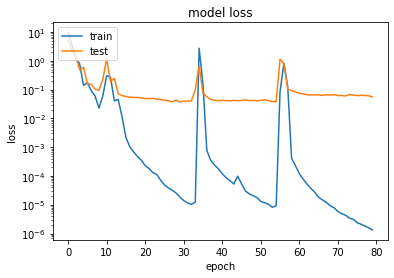

In [60]:
## summarize history for loss
## Plotting the loss with the number of iterations
plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

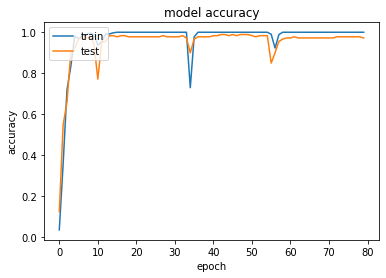

In [61]:
## Plotting the error with the number of iterations
## With each iteration the error reduces smoothly
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

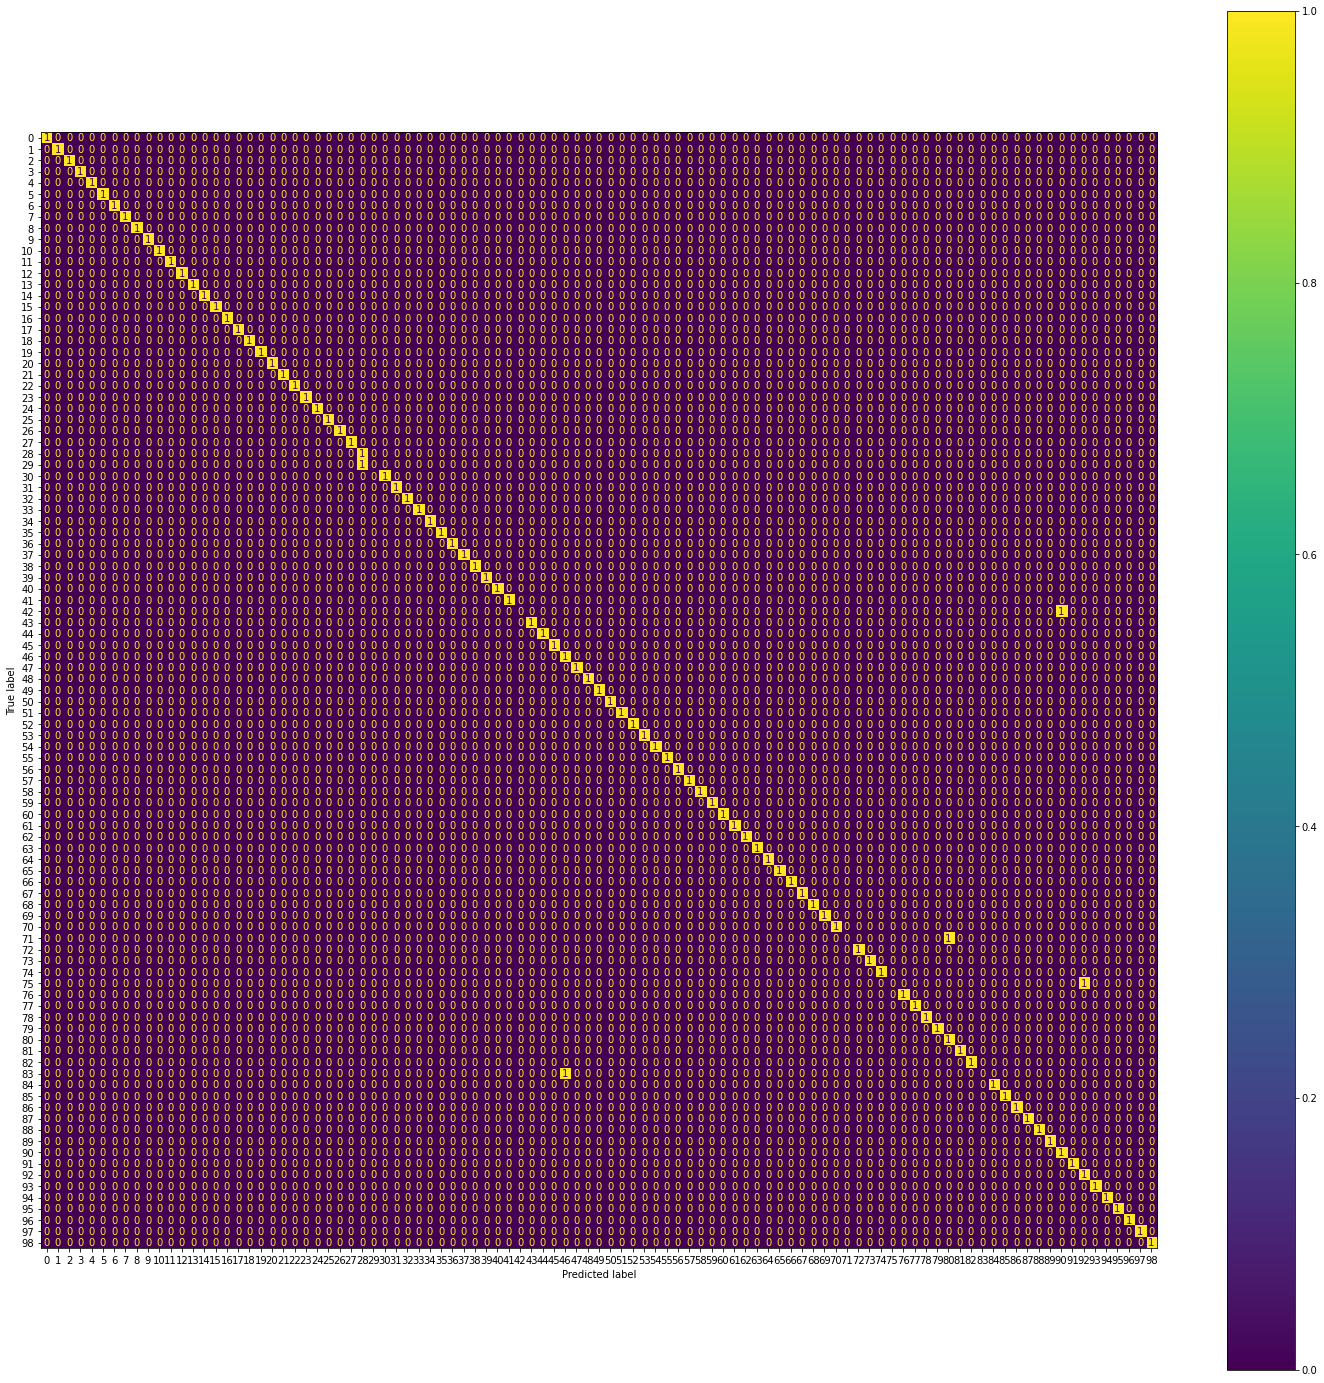

In [62]:
# Let us look at the Multi-Class Confusion Matrix 
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, confusion_matrix


y_test_pred = np.argmax(model_4.predict(X_test_r), axis=-1)
y_test_max = np.argmax(y_test, axis=-1)


cm_mat = confusion_matrix(y_test_max, y_test_pred)
cmd = ConfusionMatrixDisplay(cm_mat)

fig, ax = plt.subplots(figsize=(25,25))
cmd.plot(ax=ax)



In [67]:
# Let us try to plot the MultiClass ROC, let us load this library

!pip install yellowbrick

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
     |████████████████████████████████| 274 kB 758 kB/s eta 0:00:01
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [ ]:
import yellowbrick.classifier import ROCAUC

def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, encoder={0: 'functional', 
                                        1: 'needs repair', 
                                        2: 'nonfunctional'})
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

In [ ]:
# MultiClass ROC Curve 

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle


n_classes = nb_class

# roc curve for classes

classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=0))
y_score = classifier.fit(X_train_r, y_train).decision_function(X_test_r)


fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_max[:, i], y_test_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()



In [63]:
# Kaggle Submission 2 
preds_test = model_4.predict(test_dataset)
submission = pd.DataFrame(preds_test, columns=classes)
submission.insert(0, 'id', test_ids)
submission
submission.to_csv('submission_CNN_4.csv', index=False)
print('Submission done!')


Submission done!


In [75]:
# Model 5 and Kaggle Submission with test set provided

model_5 = Sequential()
model_5.add(Convolution1D(1024, 1, input_shape=(nb_features, 3)))
model_5.add(Activation('relu'))
model_5.add(Flatten())
model_5.add(Dropout(0.4))
model_5.add(Dense(2048, activation='relu'))
model_5.add(Dense(1024, activation='relu'))
model_5.add(Dense(512, activation='relu'))
model_5.add(Dense(nb_class))
model_5.add(Activation('softmax'))


In [76]:
# Compile and Train the Model 5 
# Here we are using the Adam optimizer instead of SGD 




model_5.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])

cb1 = EarlyStopping(patience = 3, restore_best_weights=True, monitor = 'val_acc')
cb2 = ReduceLROnPlateau(patience = 4, min_lr=0.00001, factor = 0.4, monitor = 'val_acc')


history = model_5.fit(X_train_r, y_train, epochs=80, validation_split=0.2, batch_size=128, callbacks = [cb1, cb2], verbose = 1)





Epoch 1/80
6/6 [==============================] - 7s 1s/step - loss: 3.9403 - accuracy: 0.1503 - val_loss: 2.3851 - val_accuracy: 0.4469 - lr: 5.0000e-04
Epoch 2/80
6/6 [==============================] - 6s 1s/step - loss: 1.2267 - accuracy: 0.7346 - val_loss: 0.6385 - val_accuracy: 0.8268 - lr: 5.0000e-04
Epoch 3/80
6/6 [==============================] - 6s 1s/step - loss: 0.4264 - accuracy: 0.9017 - val_loss: 0.4445 - val_accuracy: 0.8659 - lr: 5.0000e-04
Epoch 4/80
6/6 [==============================] - 6s 1s/step - loss: 0.1892 - accuracy: 0.9508 - val_loss: 0.2791 - val_accuracy: 0.9218 - lr: 5.0000e-04
Epoch 5/80
6/6 [==============================] - 7s 1s/step - loss: 0.1174 - accuracy: 0.9691 - val_loss: 0.1194 - val_accuracy: 0.9721 - lr: 5.0000e-04
Epoch 6/80
6/6 [==============================] - 6s 1s/step - loss: 0.0518 - accuracy: 0.9888 - val_loss: 0.1089 - val_accuracy: 0.9665 - lr: 5.0000e-04
Epoch 7/80
6/6 [==============================] - 7s 1s/step - loss: 0.0403 

Epoch 16/80
6/6 [==============================] - 7s 1s/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0528 - val_accuracy: 0.9944 - lr: 5.0000e-04
Epoch 17/80
6/6 [==============================] - 6s 1s/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0465 - val_accuracy: 0.9944 - lr: 5.0000e-04
Epoch 18/80
6/6 [==============================] - 7s 1s/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0418 - val_accuracy: 1.0000 - lr: 5.0000e-04
Epoch 19/80
6/6 [==============================] - 6s 1s/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0407 - val_accuracy: 0.9944 - lr: 5.0000e-04
Epoch 20/80
6/6 [==============================] - 7s 1s/step - loss: 7.7914e-04 - accuracy: 1.0000 - val_loss: 0.0395 - val_accuracy: 0.9944 - lr: 5.0000e-04
Epoch 21/80
6/6 [==============================] - 7s 1s/step - loss: 6.5494e-04 - accuracy: 1.0000 - val_loss: 0.0374 - val_accuracy: 0.9944 - lr: 5.0000e-04
Epoch 22/80
6/6 [==============================] - 7s 1s/step 

Epoch 31/80
6/6 [==============================] - 7s 1s/step - loss: 2.1747e-04 - accuracy: 1.0000 - val_loss: 0.0290 - val_accuracy: 0.9944 - lr: 5.0000e-04
Epoch 32/80
6/6 [==============================] - 6s 1s/step - loss: 1.9985e-04 - accuracy: 1.0000 - val_loss: 0.0292 - val_accuracy: 0.9944 - lr: 5.0000e-04
Epoch 33/80
6/6 [==============================] - 6s 1s/step - loss: 1.8454e-04 - accuracy: 1.0000 - val_loss: 0.0290 - val_accuracy: 0.9944 - lr: 5.0000e-04
Epoch 34/80
6/6 [==============================] - 7s 1s/step - loss: 1.6951e-04 - accuracy: 1.0000 - val_loss: 0.0286 - val_accuracy: 0.9944 - lr: 5.0000e-04
Epoch 35/80
6/6 [==============================] - 8s 1s/step - loss: 1.6116e-04 - accuracy: 1.0000 - val_loss: 0.0281 - val_accuracy: 0.9944 - lr: 5.0000e-04
Epoch 36/80
6/6 [==============================] - 7s 1s/step - loss: 1.4964e-04 - accuracy: 1.0000 - val_loss: 0.0278 - val_accuracy: 0.9944 - lr: 5.0000e-04
Epoch 37/80
6/6 [=============================

6/6 [==============================] - 6s 1s/step - loss: 8.8057e-05 - accuracy: 1.0000 - val_loss: 0.0251 - val_accuracy: 1.0000 - lr: 5.0000e-04
Epoch 46/80
6/6 [==============================] - 7s 1s/step - loss: 8.3746e-05 - accuracy: 1.0000 - val_loss: 0.0240 - val_accuracy: 1.0000 - lr: 5.0000e-04
Epoch 47/80
6/6 [==============================] - 7s 1s/step - loss: 7.9868e-05 - accuracy: 1.0000 - val_loss: 0.0233 - val_accuracy: 1.0000 - lr: 5.0000e-04
Epoch 48/80
6/6 [==============================] - 7s 1s/step - loss: 7.5685e-05 - accuracy: 1.0000 - val_loss: 0.0236 - val_accuracy: 1.0000 - lr: 5.0000e-04
Epoch 49/80
6/6 [==============================] - 7s 1s/step - loss: 7.1875e-05 - accuracy: 1.0000 - val_loss: 0.0238 - val_accuracy: 1.0000 - lr: 5.0000e-04
Epoch 50/80
6/6 [==============================] - 7s 1s/step - loss: 6.6585e-05 - accuracy: 1.0000 - val_loss: 0.0235 - val_accuracy: 1.0000 - lr: 5.0000e-04
Epoch 51/80
6/6 [==============================] - 7s 1s/s

6/6 [==============================] - 6s 1s/step - loss: 4.4274e-05 - accuracy: 1.0000 - val_loss: 0.0223 - val_accuracy: 1.0000 - lr: 5.0000e-04
Epoch 61/80
6/6 [==============================] - 6s 1s/step - loss: 4.1907e-05 - accuracy: 1.0000 - val_loss: 0.0220 - val_accuracy: 1.0000 - lr: 5.0000e-04
Epoch 62/80
6/6 [==============================] - 6s 1s/step - loss: 4.0987e-05 - accuracy: 1.0000 - val_loss: 0.0218 - val_accuracy: 1.0000 - lr: 5.0000e-04
Epoch 63/80
6/6 [==============================] - 7s 1s/step - loss: 4.0074e-05 - accuracy: 1.0000 - val_loss: 0.0217 - val_accuracy: 1.0000 - lr: 5.0000e-04
Epoch 64/80
6/6 [==============================] - 7s 1s/step - loss: 3.8073e-05 - accuracy: 1.0000 - val_loss: 0.0214 - val_accuracy: 1.0000 - lr: 5.0000e-04
Epoch 65/80
6/6 [==============================] - 7s 1s/step - loss: 3.7892e-05 - accuracy: 1.0000 - val_loss: 0.0215 - val_accuracy: 1.0000 - lr: 5.0000e-04
Epoch 66/80
6/6 [==============================] - 7s 1s/s

6/6 [==============================] - 6s 1s/step - loss: 2.7211e-05 - accuracy: 1.0000 - val_loss: 0.0203 - val_accuracy: 1.0000 - lr: 5.0000e-04
Epoch 76/80
6/6 [==============================] - 6s 1s/step - loss: 2.5918e-05 - accuracy: 1.0000 - val_loss: 0.0202 - val_accuracy: 1.0000 - lr: 5.0000e-04
Epoch 77/80
6/6 [==============================] - 7s 1s/step - loss: 2.5320e-05 - accuracy: 1.0000 - val_loss: 0.0201 - val_accuracy: 1.0000 - lr: 5.0000e-04
Epoch 78/80
6/6 [==============================] - 6s 1s/step - loss: 2.3817e-05 - accuracy: 1.0000 - val_loss: 0.0199 - val_accuracy: 1.0000 - lr: 5.0000e-04
Epoch 79/80
6/6 [==============================] - 6s 1s/step - loss: 2.4399e-05 - accuracy: 1.0000 - val_loss: 0.0194 - val_accuracy: 1.0000 - lr: 5.0000e-04
Epoch 80/80
6/6 [==============================] - 7s 1s/step - loss: 2.3055e-05 - accuracy: 1.0000 - val_loss: 0.0196 - val_accuracy: 1.0000 - lr: 5.0000e-04


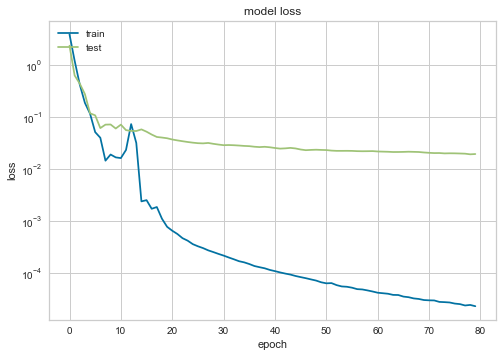

In [77]:
## summarize history for loss
## Plotting the loss with the number of iterations
plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

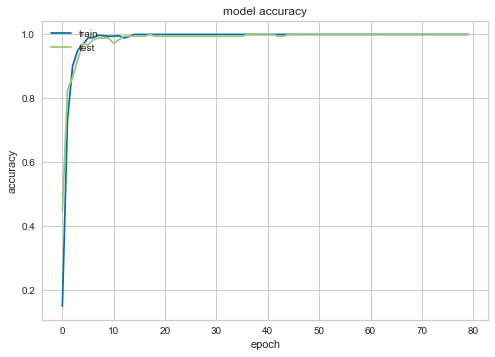

In [78]:
## Plotting the error with the number of iterations
## With each iteration the error reduces smoothly
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

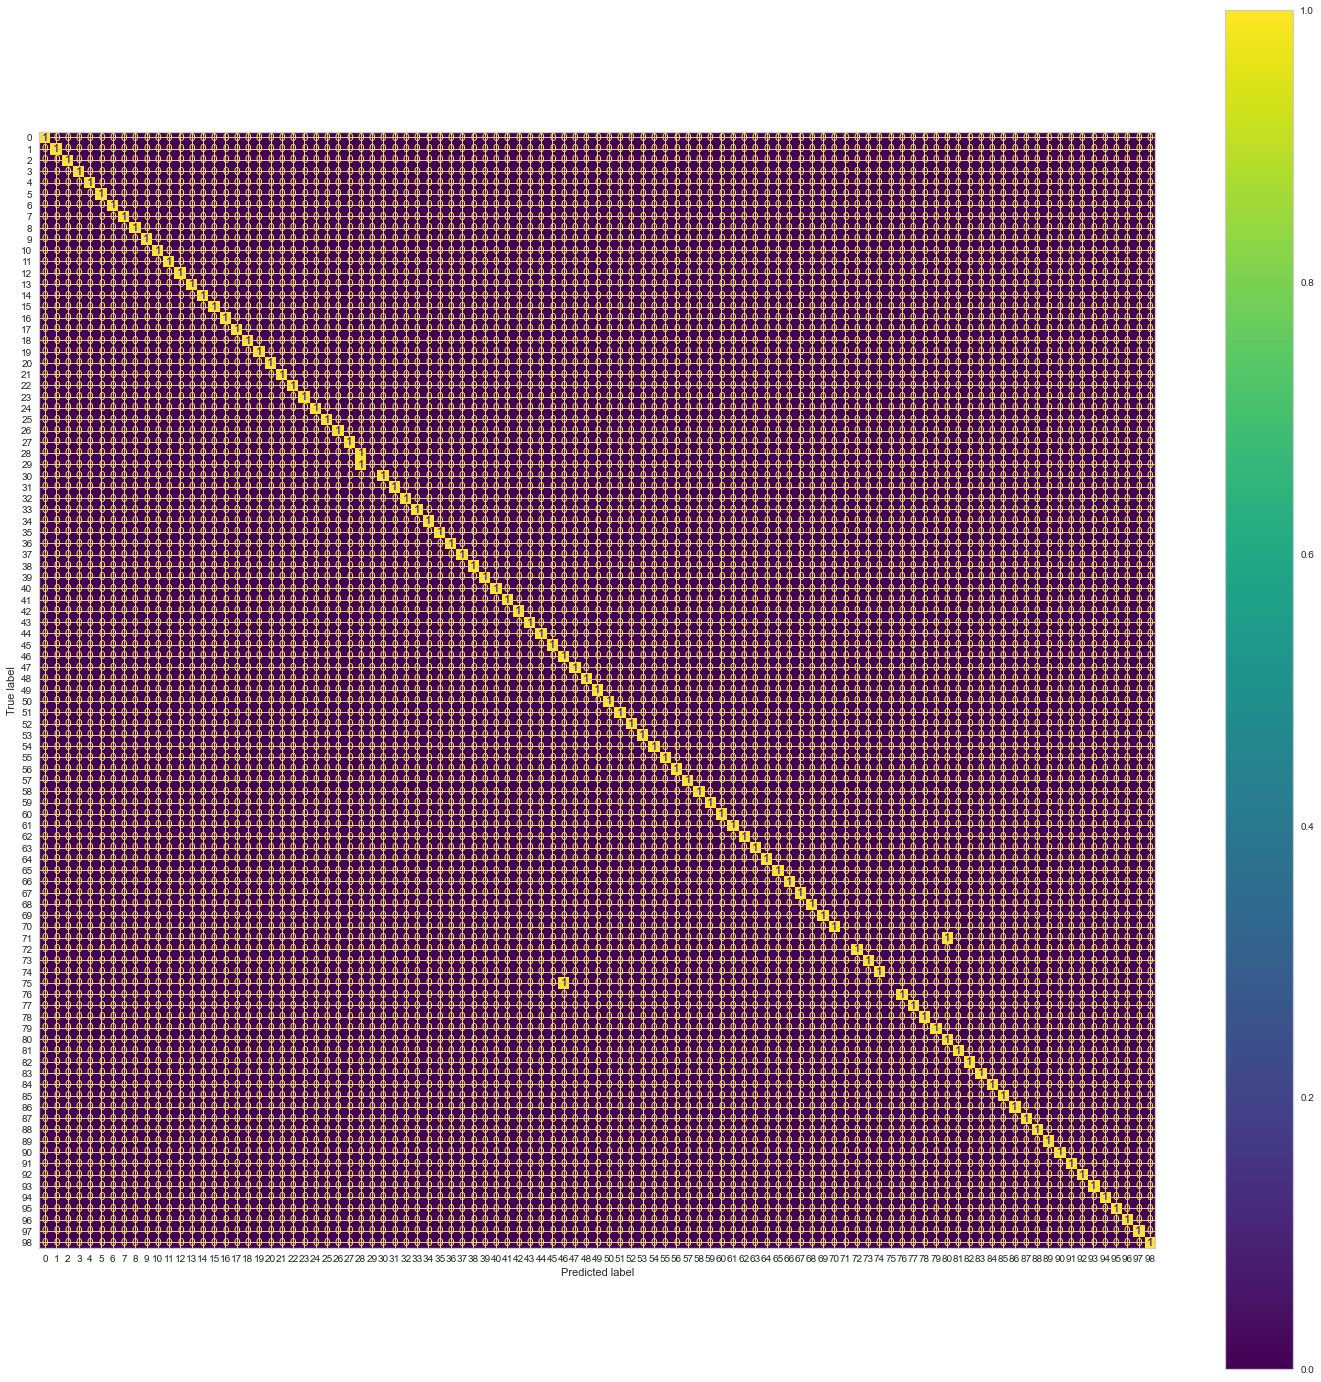

In [79]:
# Let us look at the Multi-Class Confusion Matrix 
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, confusion_matrix


y_test_pred = np.argmax(model_5.predict(X_test_r), axis=-1)
y_test_max = np.argmax(y_test, axis=-1)


cm_mat = confusion_matrix(y_test_max, y_test_pred)
cmd = ConfusionMatrixDisplay(cm_mat)

fig, ax = plt.subplots(figsize=(25,25))
cmd.plot(ax=ax)

In [80]:
# Kaggle Submission 3

preds_test = model_5.predict(test_dataset)
submission = pd.DataFrame(preds_test, columns=classes)
submission.insert(0, 'id', test_ids)
submission
submission.to_csv('submission_CNN_5.csv', index=False)
print('Submission done!')

Submission done!


In [81]:
submission

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
0,4,3.856117e-11,4.405457e-13,1.907766e-11,3.897585e-11,1.380143e-11,2.665219e-09,1.542820e-12,1.772879e-11,4.373375e-13,...,2.571842e-17,1.269783e-10,1.568479e-13,1.783535e-11,3.060800e-12,3.534278e-13,3.258406e-14,6.876761e-15,1.441122e-09,9.689426e-16
1,7,6.606881e-12,3.031590e-09,4.668086e-08,2.137310e-06,7.830516e-11,6.298159e-10,9.026559e-08,8.864087e-11,5.779153e-13,...,1.164862e-10,4.773763e-10,1.522047e-12,6.148270e-11,8.247613e-14,3.177686e-08,5.658794e-11,1.653766e-07,2.834081e-13,5.791944e-09
2,9,1.025568e-10,9.999045e-01,3.500217e-11,2.156048e-10,6.396819e-05,1.190988e-08,2.516363e-09,4.585507e-07,2.439719e-09,...,1.274213e-11,7.314771e-13,6.591716e-13,1.648169e-09,8.832048e-14,2.573977e-10,3.909761e-10,8.936372e-12,1.966551e-14,3.714348e-06
3,12,2.107389e-08,3.882442e-02,2.186954e-08,3.596350e-08,9.083999e-09,2.755644e-07,2.129889e-04,7.948108e-08,8.542022e-07,...,1.725610e-08,5.240775e-09,1.521890e-08,8.854007e-09,6.170757e-11,1.155252e-04,1.351925e-03,3.153004e-09,4.408436e-14,6.141304e-04
4,13,7.859147e-07,2.430760e-08,4.556476e-12,1.146936e-12,2.556061e-10,3.446856e-12,3.232940e-10,2.686917e-10,1.593383e-06,...,5.126017e-11,1.215639e-12,6.408670e-09,1.465069e-11,5.716625e-09,4.096748e-09,6.982588e-07,2.131146e-12,2.523973e-12,7.099740e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,1576,5.267627e-10,9.999812e-01,2.410636e-11,6.546605e-11,4.383482e-06,9.590396e-10,3.991778e-09,6.628486e-08,4.411633e-09,...,5.544078e-12,1.534249e-12,1.596563e-12,8.364509e-10,1.439485e-13,2.065399e-10,2.744302e-09,4.627279e-12,1.207939e-14,1.795933e-06
590,1577,1.044091e-08,4.938500e-08,6.239172e-11,1.795076e-08,6.487920e-12,1.126247e-08,3.062676e-10,1.344792e-06,1.872188e-07,...,1.080826e-11,1.632922e-10,2.345712e-08,7.322047e-10,4.350852e-08,3.745759e-07,1.794253e-09,4.257502e-13,2.771550e-14,4.576138e-08
591,1579,2.591023e-09,7.311410e-10,2.758081e-10,1.705653e-10,4.222476e-09,1.625324e-07,2.634637e-10,2.163613e-09,3.180302e-13,...,4.513631e-14,2.384378e-12,9.029260e-11,4.064944e-10,5.601764e-12,1.971035e-11,5.663179e-13,2.769810e-10,1.445549e-10,2.897448e-10
592,1580,9.760152e-13,2.558546e-09,2.721273e-07,5.182070e-11,9.956575e-11,5.987231e-11,7.688968e-09,2.446789e-09,3.228073e-13,...,2.052492e-08,2.792164e-08,7.543491e-15,9.487561e-10,1.070088e-13,2.243264e-11,2.755984e-12,1.238828e-07,2.391890e-14,3.476144e-08


In [85]:
# Let us try one for time for better Kaggle score using the SGD optimier with some hyper-paramter tuning.

model_6 = Sequential()
model_6.add(Convolution1D(512, 1, input_shape=(nb_features, 3)))
model_6.add(Activation('relu'))
model_6.add(Flatten())
model_6.add(Dropout(0.4))
model_6.add(Dense(2048, activation='relu'))
model_6.add(Dense(1024, activation='relu'))
model_6.add(Dense(200, activation='relu'))
model_6.add(Dense(nb_class))
model_6.add(Activation('softmax'))


sgd = SGD(lr=0.01, nesterov=True, decay=1e-6, momentum=0.9)
model_6.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

cb1 = EarlyStopping(patience = 3, restore_best_weights=True, monitor = 'val_acc')
cb2 = ReduceLROnPlateau(patience = 4, min_lr=0.00001, factor = 0.4, monitor = 'val_acc')


history = model_6.fit(X_train_r, y_train, epochs=25, validation_split=0.2, batch_size=128, callbacks = [cb1, cb2], verbose = 1)




Epoch 1/25
6/6 [==============================] - 3s 496ms/step - loss: 4.5922 - accuracy: 0.0154 - val_loss: 4.5578 - val_accuracy: 0.0335 - lr: 0.0100
Epoch 2/25
6/6 [==============================] - 3s 519ms/step - loss: 4.5328 - accuracy: 0.0548 - val_loss: 4.4874 - val_accuracy: 0.1061 - lr: 0.0100
Epoch 3/25
6/6 [==============================] - 3s 502ms/step - loss: 4.4461 - accuracy: 0.1390 - val_loss: 4.3843 - val_accuracy: 0.1899 - lr: 0.0100
Epoch 4/25
6/6 [==============================] - 3s 508ms/step - loss: 4.3107 - accuracy: 0.2275 - val_loss: 4.2265 - val_accuracy: 0.2346 - lr: 0.0100
Epoch 5/25
6/6 [==============================] - 3s 509ms/step - loss: 4.0948 - accuracy: 0.2725 - val_loss: 4.0097 - val_accuracy: 0.2626 - lr: 0.0100
Epoch 6/25
6/6 [==============================] - 3s 589ms/step - loss: 3.7767 - accuracy: 0.3862 - val_loss: 3.6944 - val_accuracy: 0.3966 - lr: 0.0100
Epoch 7/25
6/6 [==============================] - 3s 577ms/step - loss: 3.3001 - a

Epoch 16/25
6/6 [==============================] - 4s 590ms/step - loss: 0.0442 - accuracy: 0.9972 - val_loss: 0.1459 - val_accuracy: 0.9777 - lr: 0.0100
Epoch 17/25
6/6 [==============================] - 4s 634ms/step - loss: 0.0366 - accuracy: 0.9958 - val_loss: 0.1364 - val_accuracy: 0.9777 - lr: 0.0100
Epoch 18/25
6/6 [==============================] - 3s 559ms/step - loss: 0.0266 - accuracy: 0.9986 - val_loss: 0.1212 - val_accuracy: 0.9832 - lr: 0.0100
Epoch 19/25
6/6 [==============================] - 3s 537ms/step - loss: 0.0259 - accuracy: 0.9972 - val_loss: 0.1149 - val_accuracy: 0.9832 - lr: 0.0100
Epoch 20/25
6/6 [==============================] - 3s 548ms/step - loss: 0.0201 - accuracy: 1.0000 - val_loss: 0.1179 - val_accuracy: 0.9777 - lr: 0.0100
Epoch 21/25
6/6 [==============================] - 3s 539ms/step - loss: 0.0229 - accuracy: 0.9972 - val_loss: 0.1059 - val_accuracy: 0.9777 - lr: 0.0100
Epoch 22/25
6/6 [==============================] - 3s 585ms/step - loss: 0.0

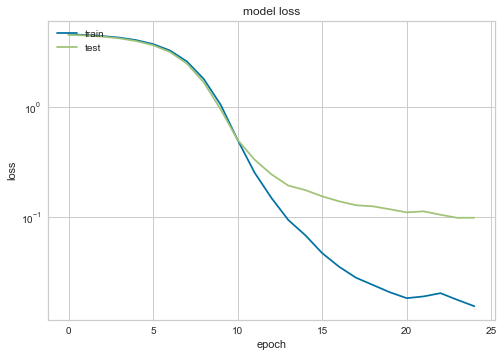

In [83]:
## summarize history for loss
## Plotting the loss with the number of iterations
plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

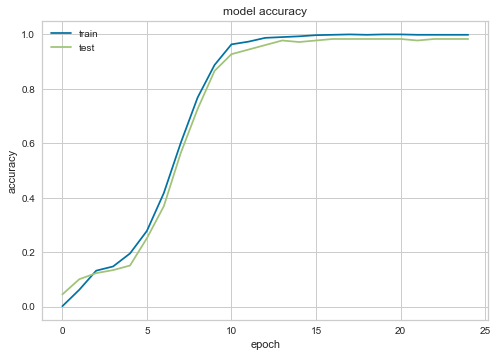

In [84]:
## Plotting the error with the number of iterations
## With each iteration the error reduces smoothly
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

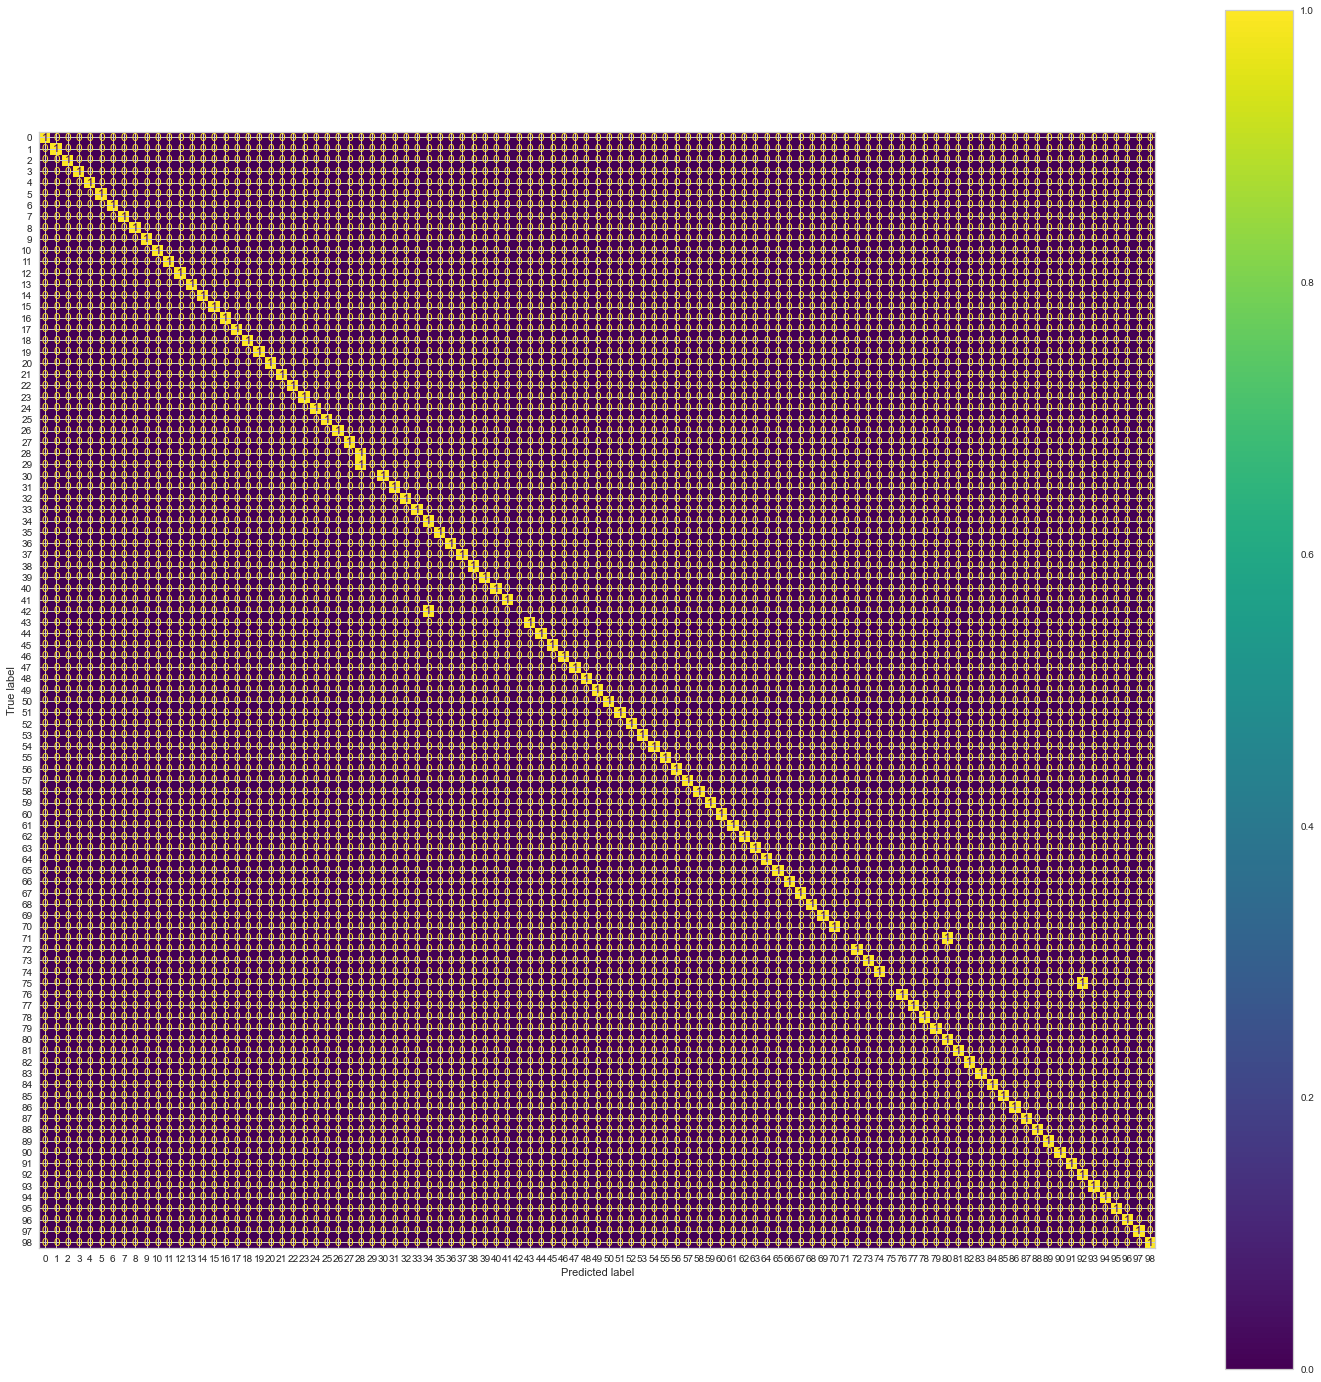

In [86]:
# Let us look at the Multi-Class Confusion Matrix 
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, confusion_matrix


y_test_pred = np.argmax(model_6.predict(X_test_r), axis=-1)
y_test_max = np.argmax(y_test, axis=-1)


cm_mat = confusion_matrix(y_test_max, y_test_pred)
cmd = ConfusionMatrixDisplay(cm_mat)

fig, ax = plt.subplots(figsize=(25,25))
cmd.plot(ax=ax)

In [87]:
# Kaggle Submission 4

preds_test = model_5.predict(test_dataset)
submission = pd.DataFrame(preds_test, columns=classes)
submission.insert(0, 'id', test_ids)
submission
submission.to_csv('submission_CNN_6.csv', index=False)
print('Submission done!')

Submission done!


# Models Summary
  Convolutional Neural Networks are very widely used in image recogniton and computer vision. With the filters, pools and connected layers it is a very powerful tool. Here I have processed the image files through the convolutional filters, I had to reshape the image to 96x96 matrix and pass it through the CNN. The models 2 and 3 use this and got accuracy of around 93 with limited CPU/GPU power.
  The Kaggle submission requires us to use the train and test data, and not the images I believe. So I have created 3 Kaggle submiisosn with CNNs trained on train-data features provided by Kaggle, and using test-data for prediction.
  I observed when I increaed the filter count to 1024, although the training, validation accuracy increased and merged, the Kaggle score dropped. So I reverted the increase. Same with adding more dense layers didn't improve the results much. Here we have 6 CNN models, and 4 Kaggle submisisons.
  

